In [20]:
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords as stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from datetime import datetime
from matplotlib.pyplot import figure
from pandas.plotting import register_matplotlib_converters
from PIL import Image
from imgurpython import ImgurClient
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import praw
import string
import nltk
import math
import logging
nltk.download('stopwords')
register_matplotlib_converters()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\granb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Access tokens

Access tokens for the various services that are used in the Notbook. To get you own, please visit [this page for Reddit client id, secret and user agent](https://github.com/reddit-archive/reddit/wiki/OAuth2-Quick-Start-Example#first-steps) and [this page for imgur client id, client secret, access toekn and refresh token](https://apidocs.imgur.com/?version=latest).

In [300]:
reddit_client_id = ""
reddit_client_secret = ""
reddit_username = ""
reddit_password = ""
reddit_user_agent = ""
imgur_client_id = ""
imgur_client_secret = ""
imgur_access_token = ""
imgur_refresh_token = ""

# Creating Imgur client

Creates an Imgur client that will allow us to upload our images. This is done using [imgurpython](https://github.com/Imgur/imgurpython).

In [4]:
client = ImgurClient(imgur_client_id, imgur_client_secret, imgur_access_token, imgur_refresh_token)

# Creating a Reddit instance

This Reddit instance is what we will use to interact with Reddit, this is created using [PRAW](https://praw.readthedocs.io/en/latest/index.html).

In [29]:
reddit = praw.Reddit(client_id=reddit_client_id, client_secret=reddit_client_secret, user_agent=reddit_user_agent
                    ,username=reddit_username, password=reddit_password)

# Fetching comments

Gets the 1000 latest comments for a given username. That number is a restriction of the Reddit API and it is currently impossible to get more than 1000 comments.

In [6]:
def get_comments(username):
    user = reddit.redditor(username)
    comment_list = list(user.comments.new(limit=None))
    output = "|Number of comments for {}:|{} (max 1000)|\n".format(username, len(comment_list))
    return output, comment_list

# Reddit comments LDA

### Defining stopwords

We use the stopwords from [NTLK](https://www.nltk.org/), but we need to add several stopwords so that the data for users that share a lot of links is not compromised.

In [7]:
stop_words = stopwords.words('english')
web_stopwords = ['www', 'http', 'https', 'com', 'org', 'jpg']
stop_words.extend(web_stopwords)

### Latent Dirichlet Allocation

Does a [LDA](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) of the user comments. We only use the $n$ comments longer than 50 characters to respect the assumption of many words per document. The hyperparameters are chosen as follows: Number of topics is chosen as $k=\max(3,\lfloor\frac{n}{100}\rfloor)$, the document topic prior is chosen as $\frac{50}{k}$ and the prior of the word per topic is chosen as $0.1$. The doc prior and topic prior are chosen following [Griffiths et al.](http://psiexp.ss.uci.edu/research/papers/sciencetopics.pdf).

The LDA is done using [sklearn's LDA implementation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html) and the data is tokenized using [sklearn's CountVectorized](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) with the stopwords defined above.

In [8]:
def LDA_comments(comments, n_topics=None, doc_prior=None, topic_prior=None):
    output = ""
    bodies = []
    MIN_LENGTH = 50
    for comment in comments:
        if len(comment.body) > MIN_LENGTH:
            bodies.append(comment.body)
    n_lda_comments = len(bodies)
    output += "|Latent Dirichlet Allocation of {} comments (length > {}):||\n".format(n_lda_comments, MIN_LENGTH)
    if n_topics == None:
        n_topics = max(3, math.floor(n_lda_comments/100))
    if doc_prior == None:
        doc_prior = 50/n_topics
    if topic_prior == None:
        topic_prior = 0.1
    vectorizer = CountVectorizer(strip_accents='unicode', stop_words=stop_words, analyzer='word')
    data = vectorizer.fit_transform(bodies)
    lda = LatentDirichletAllocation(n_components=n_topics, doc_topic_prior=doc_prior, topic_word_prior=topic_prior, random_state=42)
    lda = lda.fit(data)
    feature_names = vectorizer.get_feature_names()
    for index, topic in enumerate(lda.components_):
        best_words = np.argsort(topic)[::-1][:10]
        word_agg = ""
        for word in best_words:
            word_agg += feature_names[word] + ", "
        output += "||Topic {}: {}|\n".format(index + 1, word_agg[:-2])
    output += "\n"
    return output

# Per week comment histogram

Creates a histogram of the number of comments of the user per week.

In [9]:
def comments_histogram(comments, username):
    times = []
    TIME_QUANTUM = 60*60*24*7
    for comment in comments:
        times.append(comment.created_utc)
    minimum = min(times)
    reduced = []
    for time in times:
        reduced.append(datetime.fromtimestamp(TIME_QUANTUM*math.floor(time/TIME_QUANTUM)))
    counter = Counter(reduced)
    plt.subplots(figsize=(18,5))
    plt.bar(counter.keys(), counter.values(), width=5)
    plt.title("Histogram of {} comments for Reddit user /u/{}".format(len(comments),username))
    plt.xlabel("Date")
    plt.ylabel("Number of weekly comments")
    plt.savefig("per_week.jpg")

# Daily comments posting times

Creates a histogram of the number of comments of the user for each hour of the day.

In [10]:
def daily_comments_histogram(comments, username, utc_diff=1):
    times = []
    TIME_QUANTUM = 60*60
    for comment in comments:
        times.append(comment.created_utc)
    minimum = min(times)
    reduced = []
    for time in times:
        reduced.append((math.floor(time%(60*60*24)/TIME_QUANTUM)+utc_diff)%24)
    counter = Counter(reduced)
    plt.subplots(figsize=(18,5))
    plt.bar(counter.keys(), counter.values())
    plt.xticks([x for x in range(24)], ["{}:00".format(x) for x in range(24)])
    plt.title("Time of the day of {} comments for Reddit user /u/{}".format(len(comments),username))
    plt.xlabel("Hour in UTC{:+}".format(utc_diff))
    plt.ylabel("Number of comments during hour")
    plt.savefig("hourly.jpg")

# Most frequented subreddits

Creates a histogram of the 10 most commented to subreddits by the user.

In [11]:
def most_frequented_subreddits(comments, username):
    subreddits = []
    for comment in comments:
        subreddits.append(comment.subreddit_id)
    counter = Counter(subreddits)
    most_common = counter.most_common(10)
    subs = list(map(lambda x: "/r/" + x.display_name, reddit.info(list(list(zip(*most_common))[0]))))
    coms = list(zip(*most_common))[1]
    plt.subplots(figsize=(18,5))
    plt.bar(subs, coms)
    plt.title("Most frequenly used subreddits for Reddit user /u/{}".format(username))
    plt.xlabel("Subreddit")
    plt.ylabel("Number of comments")
    plt.savefig("subreddits.jpg")

# Most used words

Uses [sklearn's CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to find the 10 most commonly used words (except stopwords) by the user.

In [12]:
def most_used_words(comments):
    output = ""
    bodies = []
    for comment in comments:
        bodies.append(comment.body)
    vectorizer = CountVectorizer(strip_accents='unicode', stop_words=stop_words, analyzer='word')
    data = vectorizer.fit_transform(bodies)
    sum_words = data.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for idx, word in enumerate(vectorizer.get_feature_names())]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)[:10]
    word_agg = ""
    for word_freq in words_freq:
        word_agg += "{} ({} times), ".format(word_freq[0].capitalize(), word_freq[1])
    output += "|Top 10 most used words:|{}\n".format(word_agg[:-2])
    return output

# Scores analysis

Analyzes the scores of the comments of the user to find their best and worst comments, along with their average comment score.

In [13]:
def analyze_scores(comments):
    output = ""
    scores = []
    for comment in comments:
        scores.append(comment.score)
    best_scores = np.argsort(scores)[::-1]
    comment = comments[best_scores[0]]
    output += "|Best comment:|[{}]({}) ({} points, submitted to /r/{})|\n".format(comment.body.replace("\n"," "), comment.permalink, comment.score, comment.subreddit.display_name)
    comment = comments[best_scores[-1]]
    output += "|Worst comment:|[{}]({}) ({} points, submitted to /r/{})|\n".format(comment.body.replace("\n"," "), comment.permalink, comment.score, comment.subreddit.display_name)
    output += "|Average comment score:|{:.2f}|\n".format(np.mean(scores))
    return output

# Merging images

Utility to vectically merge a list of images given by filenames. This is used to merge the graphs so that only one image needs to be uploaded to Imgur.

In [14]:
def merge(filenames, output):
    images = list(map(Image.open, filenames))
    widths, heights = zip(*(i.size for i in images))
    max_width = max(widths)
    total_height = sum(heights)
    new_im = Image.new('RGB', (max_width, total_height))
    y_offset = 0
    for im in images:
        new_im.paste(im, (0,y_offset))
        y_offset += im.size[1]
    new_im.save(output)

# Uploading image to Imgur

Uploads an image using the Imgur the client we created previously.

In [15]:
def upload(filename):
    return client.upload_from_path(filename)['link']

# Creating the body of the comment

Creates the body of the comment analyzing the user given by username. The graphs are merged and uploaded to Imgur.

In [16]:
def create_body(username):
    body = "|||\n|:-|:-|\n"
    output, comments = get_comments(username)
    body += output
    body += analyze_scores(comments)
    body += most_used_words(comments)
    most_frequented_subreddits(comments, username)
    plt.close(plt.gcf())
    comments_histogram(comments, username)
    plt.close(plt.gcf())
    daily_comments_histogram(comments, username)
    plt.close(plt.gcf())
    merge(["subreddits.jpg", "per_week.jpg", "hourly.jpg"], "merged.jpg")
    body += LDA_comments(comments)
    body += "[Most used subreddits, weekly and hourly graphs]({})".format(upload("merged.jpg"))
    return body

# Checking if a Redditor exists

Utility to check whether a Redditor exists. No direct way to do that so this is pretty ugly.

In [17]:
def redditor_exists(name):
    try: 
        reddit.redditor(name).id
        return True
    except:
        return False

# Scanning new comments and replying to summons

Scans the stream of all new comments to Reddit and looks for the summoning pattern (user-analyzer-bot followed by a username). When the pattern is found, analyzes the given Redditor and replies to the comment with the analysis.

In [42]:
subreddit_to_scan = "UserAnalyzerBot"

In [ ]:
comment_stream = reddit.subreddit(subreddit_to_scan).stream.comments(skip_existing=True, pause_after=0)
while(True):
    for comment in comment_stream:
        if comment is not None and "user-analyzer-bot" in comment.body.lower():
            print("Summon by {} found!".format(comment.author.name))
            body = comment.body.lower().replace('/u/','').replace('u/','').split(' ')
            if comment.author is not reddit.user.me():
                try:
                    index = body.index("user-analyzer-bot")
                    if index+1 < len(body):
                        username = body[index+1]
                        if redditor_exists(username):
                            comment.reply(create_body(username))
                            print("Replied to request by {} regarding {}".format(comment.author.name, username))
                except:
                    logging.exception("Error")
                    print("Error while trying to reply to summon")

Summon by Bibibis found!


ERROR:root:Error
Traceback (most recent call last):
  File "<ipython-input-45-d7afa439bf85>", line 13, in <module>
    comment.reply(create_body(username))
  File "C:\Users\granb\Anaconda3\lib\site-packages\praw\models\reddit\mixins\replyable.py", line 26, in reply
    return self._reddit.post(API_PATH["comment"], data=data)[0]
  File "C:\Users\granb\Anaconda3\lib\site-packages\praw\reddit.py", line 517, in post
    return self._objector.objectify(data)
  File "C:\Users\granb\Anaconda3\lib\site-packages\praw\objector.py", line 155, in objectify
    raise APIException(*errors[0])
praw.exceptions.APIException: RATELIMIT: 'you are doing that too much. try again in 6 minutes.' on field 'ratelimit'


Error while trying to reply to summon
Summon by Bibibis found!
Replied to request by Bibibis regarding bibibis
Summon by Bibibis found!
Replied to request by Bibibis regarding bibibis
Summon by Bibibis found!
Replied to request by Bibibis regarding theliberalbot
Summon by Bibibis found!
Replied to request by Bibibis regarding keanu73
Summon by Bibibis found!
Replied to request by Bibibis regarding rediscoveringreddit
Summon by Bibibis found!
Replied to request by Bibibis regarding mister_teapot
Summon by Bibibis found!
Replied to request by Bibibis regarding drsquidbeaks
Summon by Bibibis found!
Replied to request by Bibibis regarding fwob
Summon by Bibibis found!
Replied to request by Bibibis regarding thebakingseal
Summon by Bibibis found!
Replied to request by Bibibis regarding thesobercasinoman


# Analyzing a user inside the Jupyter Notebook

Analyzes a Redditor directly in the notebook.

In [34]:
def analyze(username):
    output, comments = get_comments(username)
    print(output)
    print(LDA_comments(comments))
    print(analyze_scores(comments))
    print(most_used_words(comments))
    most_frequented_subreddits(comments, username)
    comments_histogram(comments, username)
    daily_comments_histogram(comments, username)
    plt.show()

|Number of comments for Bibibis:|996 (max 1000)|

|Latent Dirichlet Allocation of 635 comments (length > 50):||
||Topic 1: got, every, game, actually, people, time, find, make, guy, board|
||Topic 2: one, server, client, work, since, still, right, send, need, minutes|
||Topic 3: game, get, play, players, games, even, 10, first, time, every|
||Topic 4: would, barbs, even, lvl, hog, cards, right, people, single, using|
||Topic 5: see, used, probably, could, point, make, side, think, pretty, already|
||Topic 6: deck, playing, use, win, card, good, op, well, game, makes|


|Best comment:|[When this 90 year old reposter started to submit, the President leaned in and told him this had already been posted hundreds of times. This shitposter submitted, saying "But Sir, the karma."](/r/MURICA/comments/5e37wt/when_this_90_yr_old_vet_started_to_stand_up_the/da9ij3e/) (1446 points, submitted to /r/MURICA)|
|Worst comment:|[No way, Americans not understanding anything about football. Who would have 

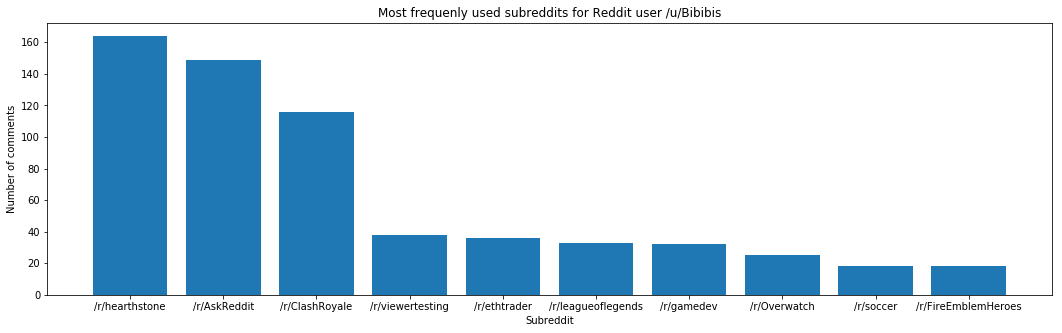

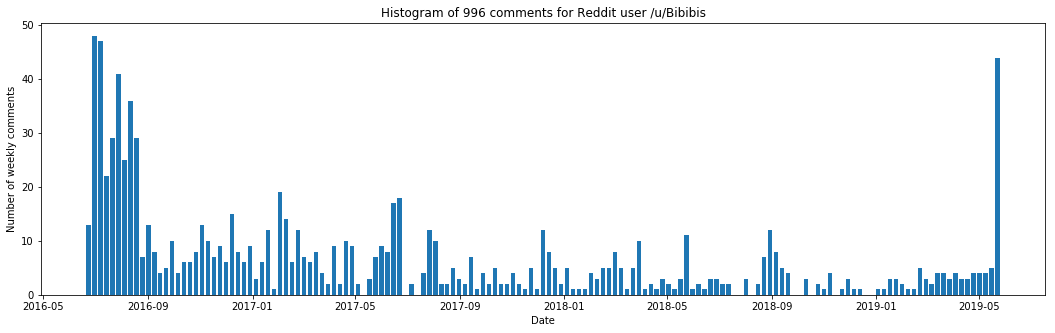

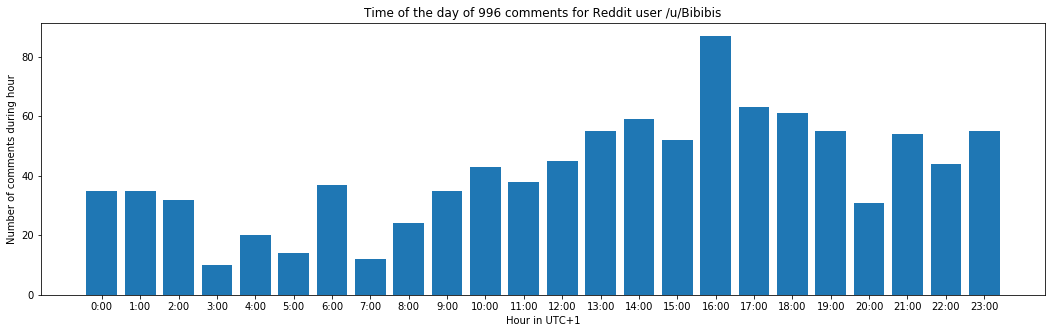

In [35]:
analyze('Bibibis')